In [ ]:
!pip install textstat
!pip install pyLDAvis 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyLDAvis-3.4.0-py3-none-any.whl (2.6 MB)
  Using cached funcy-1.18-py2.py3-none-any.whl (33 kB)


In [ ]:
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 


#utility functions:
def plot_readability(a,b,title,bins=0.1,colors=['#3A4750', '#F64E8B']):
    trace1 = ff.create_distplot([a,b], [" Real disaster tweets","Not real disaster tweets"], bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    py.iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures"," Not real disaster tweets","real disaster tweets"],
                ["Mean",mean(a),mean(b)],
                ["Standard Deviation",pstdev(a),pstdev(b)],
                ["Variance",pvariance(a),pvariance(b)],
                ["Median",median(a),median(b)],
                ["Maximum value",max(a),max(b)],
                ["Minimum value",min(a),min(b)]]
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def removeurl(raw_text):
    clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_text, flags=re.MULTILINE)
    return clean_text

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sub = pd.read_csv('./sample_submission.csv')

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train['text'] = train['text'].apply(lambda x:cleanhtml(x))
test['text'] = test['text'].apply(lambda x:cleanhtml(x))


train['text'] = train['text'].apply(lambda x:removeurl(x))
test['text'] = test['text'].apply(lambda x:removeurl(x))

In [ ]:
cnt_srs = train['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Jet',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")
fig.show(renderer="colab")

In [ ]:
cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)
fig.show(renderer="colab")

In [ ]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of tweets about real disaster location wise",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of tweets other than real disaster location wise",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)
fig.show(renderer="colab")

In [ ]:
df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
Everywhere
New York, NY
California, USA
Florida


In [ ]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

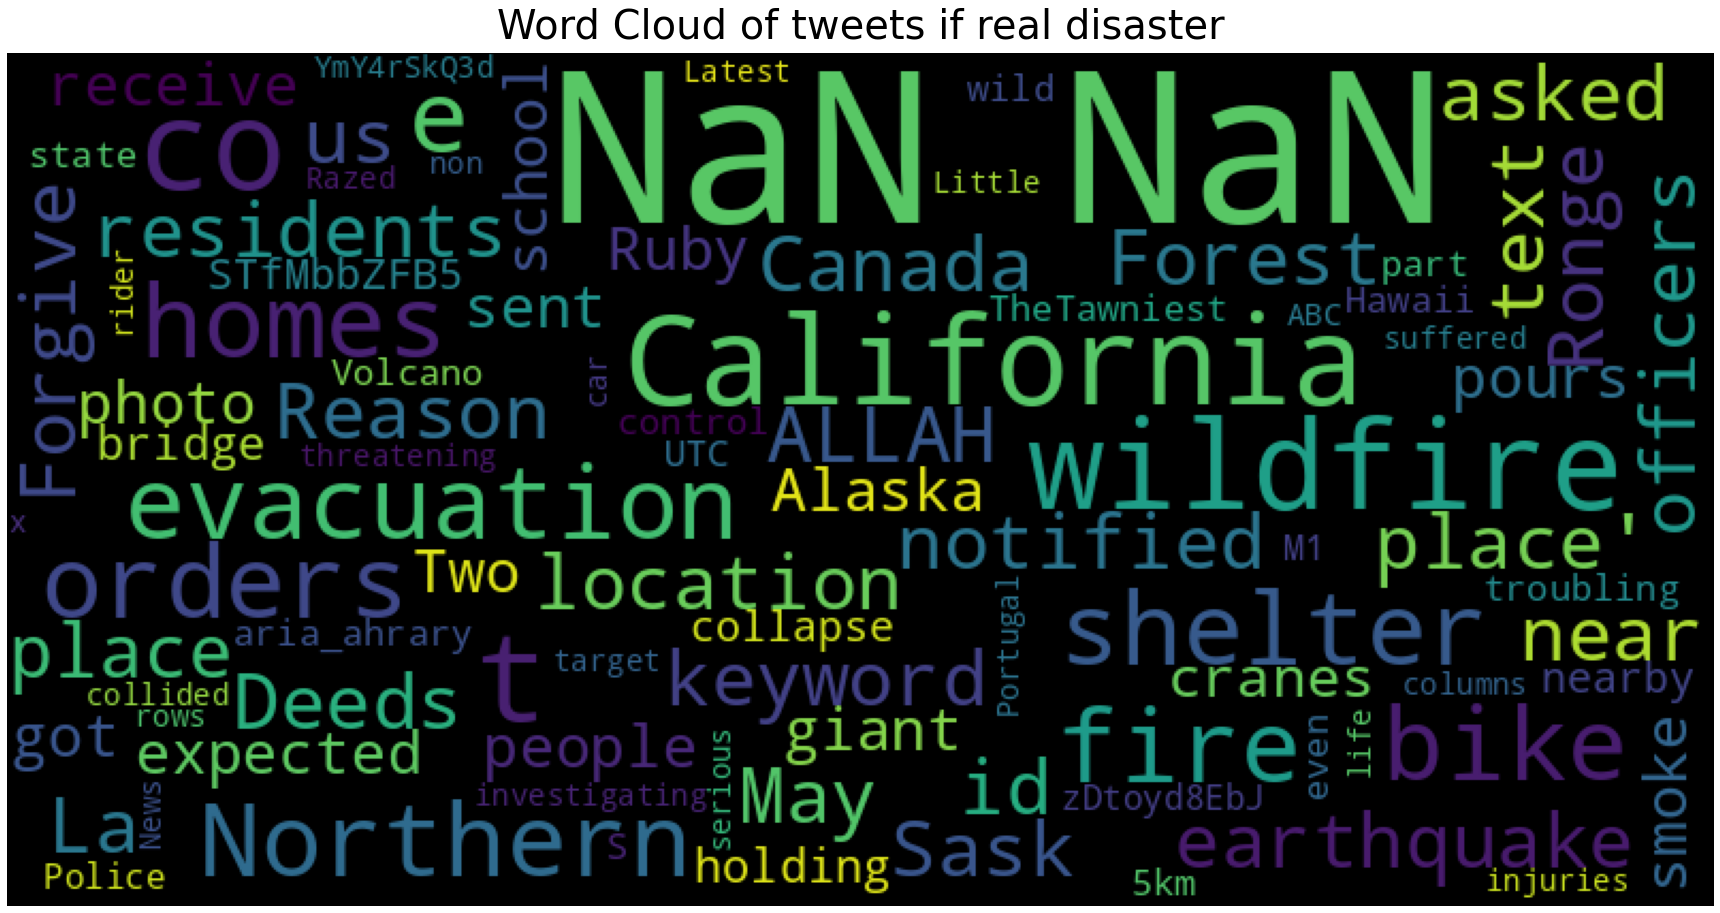

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train[train["target"]==1], title="Word Cloud of tweets if real disaster")

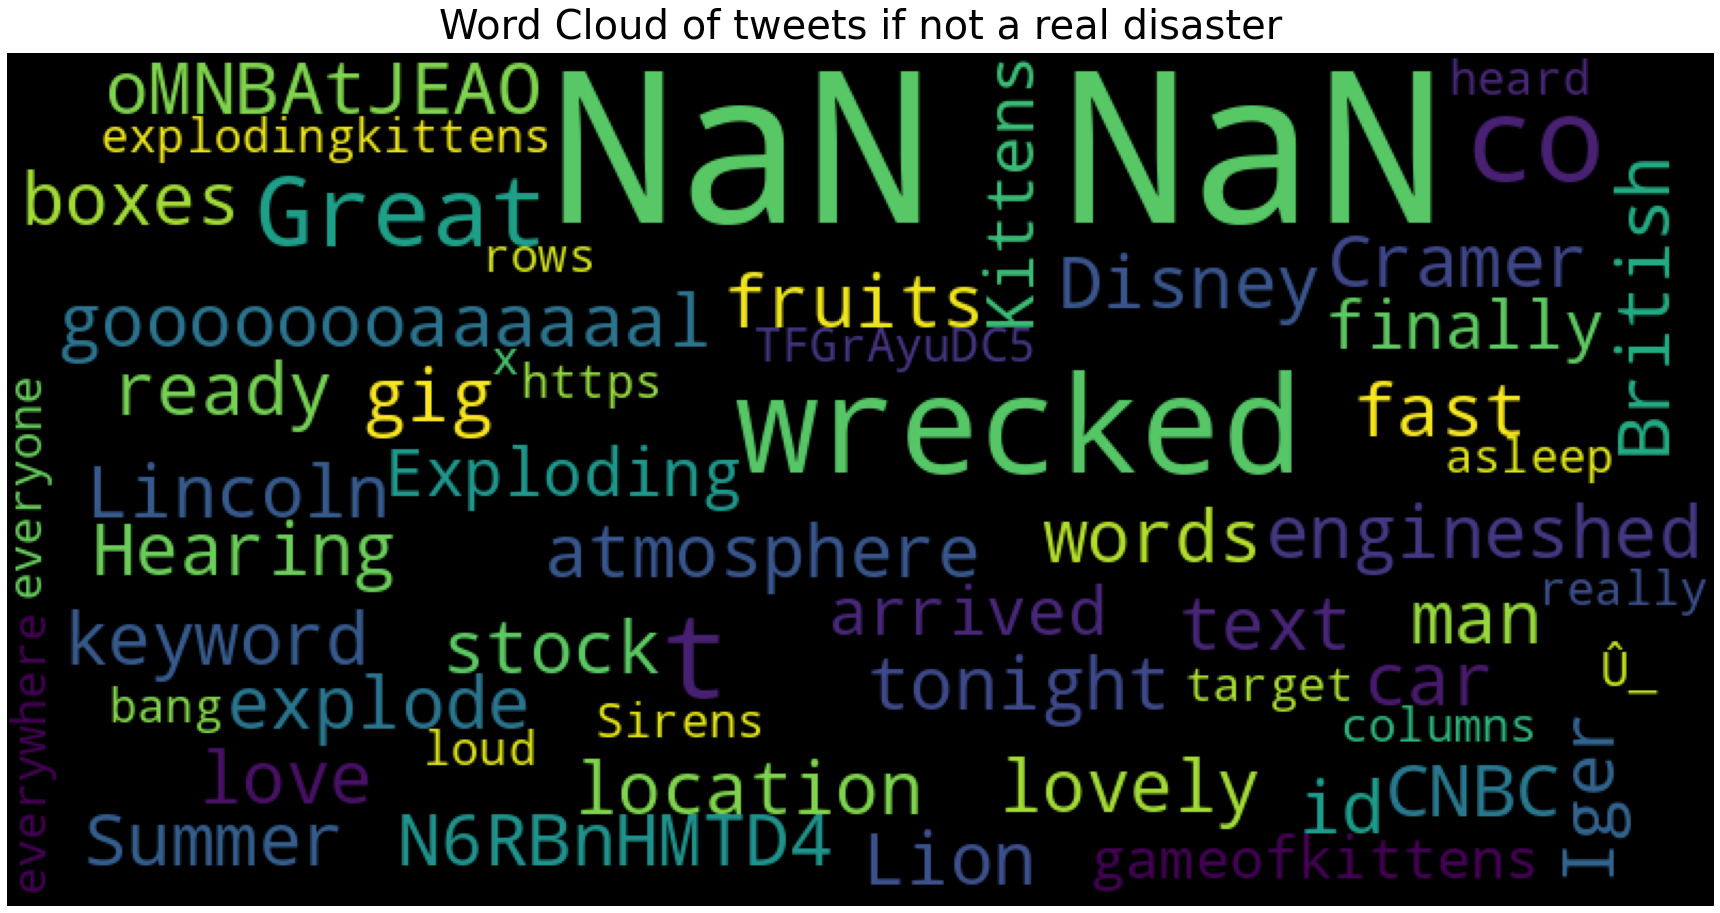

In [ ]:
plot_wordcloud(train[train["target"]==0], title="Word Cloud of tweets if not a real disaster")

In [ ]:
from collections import defaultdict
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'red')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')
fig.show(renderer="colab")

/usr/local/lib/python3.9/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/usr/local/lib/python3.9/dist-packages/plotly/basedatatypes.py:2307: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.9/dist-packages/plotly/basedatatypes.py:2307: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [ ]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')
fig.show(renderer='colab')

/usr/local/lib/python3.9/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/usr/local/lib/python3.9/dist-packages/plotly/basedatatypes.py:2307: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.9/dist-packages/plotly/basedatatypes.py:2307: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [ ]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')
fig.show(renderer='colab')

/usr/local/lib/python3.9/dist-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/usr/local/lib/python3.9/dist-packages/plotly/basedatatypes.py:2307: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.9/dist-packages/plotly/basedatatypes.py:2307: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [ ]:
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))


train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))


train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))


train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )


train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

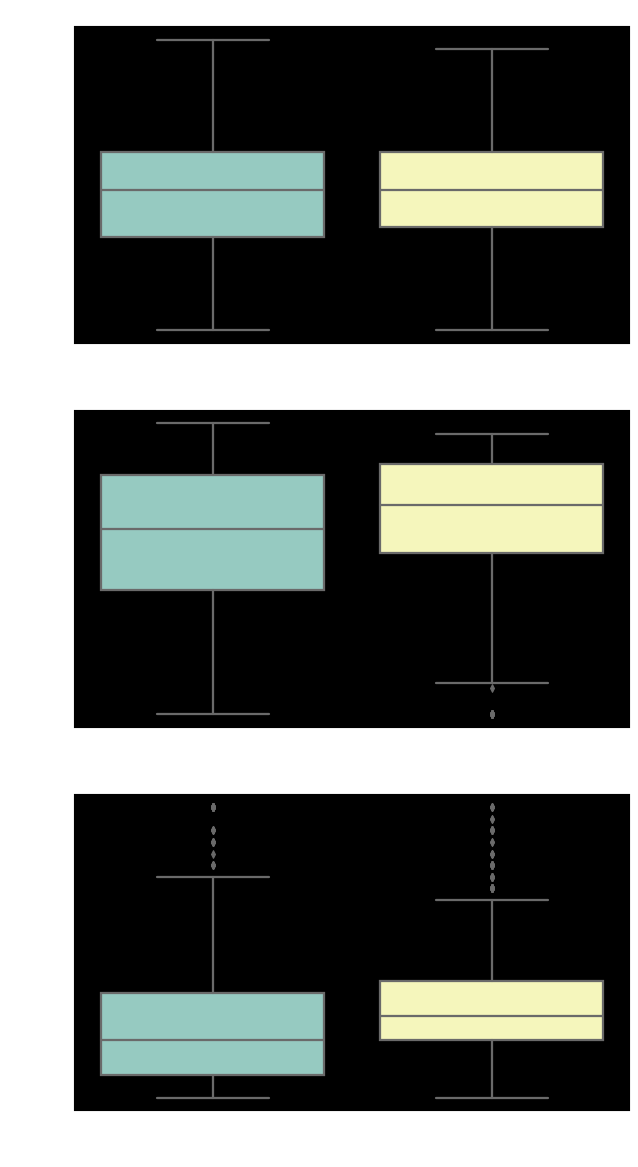

In [ ]:
train['num_words'].loc[train['num_words']>60] = 100 #truncation for better visuals
train['num_punctuations'].loc[train['num_punctuations']>25] = 25 #truncation for better visuals
train['num_chars'].loc[train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

In [ ]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_words'],name = 'Number of words in tweets about real disaster'))
fig.add_trace(go.Histogram(x=train0_df['num_words'],name = 'Number of words in tweets other than real disaster'))


fig.update_layout(barmode='stack')

fig.update_traces(opacity=0.75)
fig.show(renderer='colab')


In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_chars'],name = 'Number of chars in tweets about real disaster',marker = dict(color = 'rgba(200, 100, 0, 0.8)')))
fig.add_trace(go.Histogram(x=train0_df['num_chars'],name = 'Number of chars in tweets about real disaster',marker = dict(color = 'rgba(25, 133, 120, 0.8)')))


fig.update_layout(barmode='stack')

fig.update_traces(opacity=0.75)
fig.show(renderer='colab')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_punctuations'],name = 'Number of punctuations in tweets about real disaster',marker = dict(color = 'rgba(97, 175, 222, 0.8)')))
fig.add_trace(go.Histogram(x=train0_df['num_punctuations'],name = 'Number of punctuations in tweets other than real disaster',marker = dict(color = 'rgba(200, 10, 150, 0.8)')))


fig.update_layout(barmode='stack')

fig.update_traces(opacity=1)
fig.show(renderer='colab')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_words'],name = 'Number of words in training tweets',marker = dict(color = 'rgba(255, 0, 0, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_words'],name = 'Number of words in testing tweets ',marker = dict(color = 'rgba(0, 187, 187, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show(renderer='colab')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_chars'],name = 'Number of chars in training tweets',marker = dict(color = 'rgba(25, 13, 8, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_chars'],name = 'Number of chars in testing tweets ',marker = dict(color = 'rgba(8, 25, 187, 0.8)')))


fig.update_layout(barmode='stack')

fig.update_traces(opacity=0.75)
fig.show(renderer='colab')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_punctuations'],name = 'Number of punctuations in training tweets',marker = dict(color = 'rgba(222, 111, 33, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_punctuations'],name = 'Number of punctuations in testing tweets ',marker = dict(color = 'rgba(33, 111, 222, 0.8)')))

fig.update_layout(barmode='stack')

fig.update_traces(opacity=0.75)
fig.show(renderer='colab')

In [ ]:
tqdm.pandas()

In [ ]:
notreal_text = train["text"][train["target"] == 0].progress_apply(spacy_tokenizer)
real_text = train["text"][train["target"] == 1].progress_apply(spacy_tokenizer)
vectorizer_notreal = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
notreal_vectorized = vectorizer_notreal.fit_transform(notreal_text)
vectorizer_real = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
real_vectorized = vectorizer_real.fit_transform(real_text)

<>:4: DeprecationWarning:

invalid escape sequence \-

<>:4: DeprecationWarning:

invalid escape sequence \-

<ipython-input-56-3deeebab306e>:4: DeprecationWarning:

invalid escape sequence \-

100%|██████████| 3271/3271 [00:00<00:00, 7244.28it/s]


ValueError: ignored

In [ ]:
plot_model(lda, plot = 'topic_distribution')

In [ ]:
plot_model(lda, plot = 'topic_model')

In [ ]:
plot_model(lda, plot = 'wordcloud')

In [ ]:
plot_model(lda, plot = 'bigram')

In [ ]:
plot_model(lda, plot = 'trigram')

In [ ]:
plot_model(lda, plot = 'frequency')

In [ ]:
plot_model(lda, plot = 'pos')

In [ ]:
plot_model(lda, plot = 'umap')

In [ ]:
plot_model(lda, plot = 'tsne')